# EQUINE Toy Problem Example

The intent of this example notebook is to provide an easy-to-visualize, 2-D, toy problem that illustrates both the general problem of uncertainty quantification in neural network classification as well as to show how EQUINE can be used to make predictions more robust in the face of uncertainty.

Here, we use the `EquineGP` class to demonstrate the ideas. This class follows the approach used in Spectral-normalized Neural Gaussian Processes (SNGP), which appends random Fourier features and a Laplace approximation to a Gaussian Process (GP) to the end of a neural network, making it possible to compute out-of-distribution scores (see [deterministic uncertainty estimation](https://github.com/y0ast/DUE) and the [SNGP tutorial](https://www.tensorflow.org/tutorials/understanding/sngp)). Note that EQUINE does not assume that the user is enforcing a spectral normalization in the neural network embedding, so the results may vary.

This notebook requires some extra dependencies to run. You can uncomment the below cell to install them into your local environment.

In [1]:
#!pip install scikit-learn matplotlib

In [2]:
# Remove a TQDM warning
import warnings
warnings.filterwarnings('ignore')

import torch
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.metrics import RocCurveDisplay
from torch.utils.data import TensorDataset
from torchmetrics import Accuracy
import matplotlib.pyplot as plt

# Helpers from EQUINE
import equine as eq
from equine import brier_score, brier_skill_score, expected_calibration_error

### Generate Toy Dataset
This dataset uses `make_blobs` from scikit-learn, placing 4 clusters in each 
quadrant (for 4 classes), along with a middle cluster with random class memberships.

In this toy problem, the accuracy should not be much higher than 80%, since the middle class memberships are essentially random.

Additionally, the class confidence in the middle of the problem should hover around 25% for the same reason.

Text(0.5, 1.0, 'Class membership of training data')

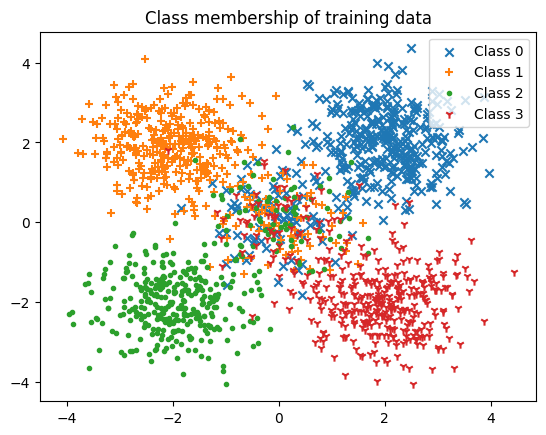

In [3]:
num_classes = 4
examples_per_class = 500
tensor_dim = 2

n_samples = examples_per_class * num_classes
centers = [ (2,2), (-2,2), (-2,-2), (2,-2), (0,0) ]
x_list, y_list = make_blobs(n_samples=n_samples, n_features=tensor_dim, 
                            centers=centers, cluster_std=0.75, shuffle=False,random_state=52)
# Randomize the classes in the middle
rng = np.random.default_rng(seed=52)
y_list[(n_samples*4//5):] = rng.integers(4, size=n_samples//5) 
X = torch.FloatTensor(x_list)
Y = torch.tensor(y_list)

dataset = torch.utils.data.TensorDataset(X,Y)
trainset, testset = torch.utils.data.random_split(dataset, [0.8, 0.2], 
                    generator=torch.Generator().manual_seed(52))
train_x = trainset.dataset.tensors[0][trainset.indices]
train_y = trainset.dataset.tensors[1][trainset.indices]
test_x  = testset.dataset.tensors[0][testset.indices]
test_y  = testset.dataset.tensors[1][testset.indices]

# Plot the training data
for class_i, marker in enumerate(["x", "+", ".", "1"]):
    xs = train_x[train_y == class_i]
    plt.scatter(xs[:,0], xs[:,1],marker=marker,label=f'Class {class_i}')
plt.legend(loc="best")
plt.title("Class membership of training data")

### Define a feature embedding model

Here we define a "usual", sequential neural network architecture, leaving off only the softmax
in the forward function. Here, we've arbitrarily selected 16 as the dimension of the 
feature embeddings (the penultimate layer), but we're classifying on the 4 output categories
from above. 

In [4]:
class EmbeddingModel(torch.nn.Module):
    def __init__(self):
        super(EmbeddingModel, self).__init__()
        self.linear_relu_stack = torch.nn.Sequential(
            torch.nn.Linear(tensor_dim, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, num_classes)
        )
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

# Note that we have left off the very last step (the softmax),
# so we'll need to apply that after the model to calculate "probabilities"

Next, we train a multiclass classification model in the usual way, using cross entropy loss and the Adam optimizer over 100 epochs (this should only take a few seconds, even on a CPU)

In [5]:
# Set up a pytorch network for training
vanilla_nn = EmbeddingModel()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vanilla_nn.parameters())

# Prepare the input data
trainloader = torch.utils.data.DataLoader(trainset,batch_size=64,shuffle=True, drop_last=True)

# Train the model
vanilla_nn.train()
for epoch in range(100):
    epoch_loss = 0.0
    for i, (xs, labels) in enumerate(trainloader):
        optimizer.zero_grad()
        yhats = vanilla_nn(xs)
        loss = loss_fn(yhats, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    if epoch%50 == 49 or epoch == 0:
        print(f"Epoch {epoch+1} has loss {epoch_loss:3.2f}")

Epoch 1 has loss 33.18
Epoch 50 has loss 8.52
Epoch 100 has loss 8.34


Before we test the results, here are a few helper functions for printing out metrics like:
* Accuracy 
* Expected Calibration Error (ECE). Closest to zero is better, implying well-calibrated NN output probabilities 
* [Brier score](https://en.wikipedia.org/wiki/Brier_score), lower is better 
* [Brier skill score](https://en.wikipedia.org/wiki/Brier_score#Brier_Skill_Score_(BSS)), as compared to random guessing (closer to 1.0 is better)

We also evaluate the NN on a 2-D mesh and plot a contour map of background confidences.

In [6]:
def display_2d_test_and_confidence(y_hat, x_test, y_test, Xt, Yt, confidences, title_in=None):
    """
    Display test points as a scatter plot against a contour plot of confidence values

    :param y_hat: NN predictions on test data
    :param x_test: X data for testing
    :param y_test: one-hot encoded ground truth labels
    :param Xt: meshgrid of Cartesian X locations for contour plot
    :param Yt: meshgrid of Cartesian Y locations for contour plot
    :param confidences: 2D torch tensor of confidences (scores between 0 and 1)
    :param title_in: Optional title for plot
    """
    # Plot class confidences on countourf and overlay test data predictions 
    y_out = torch.argmax(y_hat,1)
    fig, ax = plt.subplots()
    cf = ax.contourf(Xt.numpy(), Yt.numpy(), torch.reshape(confidences, [len(Xt),len(Yt)]), cmap=plt.cm.bone)
    fig.colorbar(cf, ax=ax)
    wrong_xs = torch.Tensor()
    for class_i, marker in enumerate(["1", "+", ".", "o"]):
        xs = x_test[(y_out == class_i) & (y_test == class_i)]
        wxs = x_test[(y_out == class_i) & (y_test != class_i)]
        wrong_xs = torch.cat((wrong_xs, wxs),0)
        ax.scatter(xs[:,0], xs[:,1],marker=marker,label=f'Class {class_i}')
    ax.scatter(wrong_xs[:,0], wrong_xs[:,1], marker="x", label="Incorrect")
    ax.legend()

    title = title_in
    if not title_in:
        title = "NN Test Predictions and Class Confidence"
    plt.title(title)


def print_metrics(y_hat, y_test, num_classes=4):
    """
    Print out accuracy, expected calibration error, and render a 2-D plot

    :param y_hat: NN predictions on test data
    :param y_test: one-hot encoded ground truth labels
    :param confidences: 2D torch tensor of confidences (scores between 0 and 1)
    """
    # Compute accuracy and ECE
    accuracy = Accuracy(task="multiclass", num_classes=num_classes, top_k=1)

    y_out = torch.argmax(y_hat,1)
    acc = accuracy(y_out, y_test)
    print(f"NN accuracy is {acc:3.2f}")
    
    ece = expected_calibration_error(y_hat, y_test)
    print(f"NN ECE is: {ece:3.2e}")
 
    bs = brier_score(y_hat, y_test)
    print(f"Brier score is: {bs:3.2e}")

    bss = brier_skill_score(y_hat, y_test)
    print(f"Brier skill score is: {bss:3.2f}")


#### Visualizing the Neural Network Uncertainty
Before continuing onto how EQUINE can help, here's how well the "vanilla" Neural Network does on this problem. Using the above function, we can show the output predictions on the held-out test data and on a uniform grid.

NN accuracy is 0.85
NN ECE is: 3.49e-02
Brier score is: 1.85e-01
Brier skill score is: 0.75


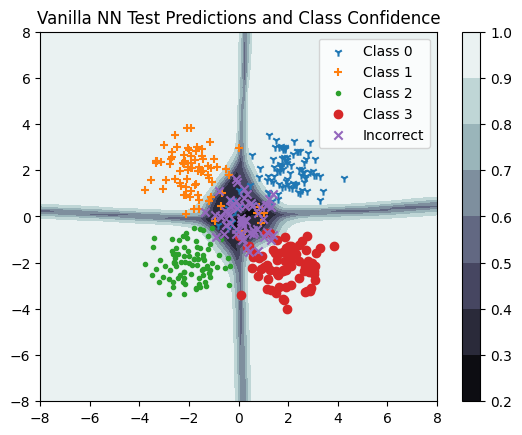

In [7]:
vanilla_nn.eval()
# Compute results on held-out test data
vanilla_results = torch.nn.Softmax(dim=1)(vanilla_nn(test_x))

# Compute confidence scores on a test grid
bbox = 8 
Xt, Yt = torch.meshgrid(torch.linspace(-bbox,bbox,steps=100), 
                        torch.linspace(-bbox,bbox,steps=100),
                        indexing='xy')
Xs = torch.cat(tuple(torch.dstack((Xt,Yt))))
vnn_results_grid=torch.nn.Softmax(dim=1)(vanilla_nn(Xs))
y_conf = torch.max(vnn_results_grid,1).values.detach()

# Evaluate the results
print_metrics(vanilla_results, test_y)
display_2d_test_and_confidence(vanilla_results, test_x, test_y, Xt, Yt, y_conf,
                            "Vanilla NN Test Predictions and Class Confidence" )

### Wrapping the Vanilla NN Feature Embedding in EQUINE
At first glance, the network is performing very well: it is getting more than 80% accuracy and is very confident about its predictions (the maximum probability is nearly 1.0 almost everywhere). However, the confidence contours reveal that the model is extremely confident everywhere except for a relatively thin boundary between the classes on the x/y axes and in the interior, random cluster. On the held-out test data, the calibration error for this simple problem is also decent. 

Next, let's consider all but the last layer of the above neural network as a "feature embedding". In this example, we use `EquineGP`, which is based upon Spectral Norm Gaussian Processes (for more background, checkout this [TensorFlow tutorial](https://www.tensorflow.org/tutorials/understanding/sngp) as well as the [PyTorch reimplementation](https://github.com/y0ast/DUE)).

To wrap the feature embedding into an Equine GP, we wrap the embedding model into an `EquineGP` class:

In [8]:
# Pull out the feature embedding
all_layers = list(vanilla_nn.children())
embedding_layers = all_layers[0][:-1] # Remove the last layer
embedding_model = torch.nn.Sequential(*embedding_layers) # Rebuild the NN

# Build an EQUINE object by wrapping the feature embedding
model = eq.EquineGP(
    embedding_model,
    emb_out_dim=16,
    num_classes=num_classes,
    use_temperature=True,
    feature_names=["x","y"],
    label_names=[f"Class {i}" for i in range(num_classes)] )

In [9]:
# Retrain using the GP -- here we use a convenience function
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
model.train_model(torch.utils.data.TensorDataset(train_x, train_y), loss_fn, optimizer, 50)

100%|██████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 12.57it/s]


({'numTrainExamples': [{'label': 0, 'numExamples': 360},
   {'label': 1, 'numExamples': 369},
   {'label': 2, 'numExamples': 353},
   {'label': 3, 'numExamples': 358}],
  'dateTrained': '09/16/2024, 13:57:32',
  'modelType': 'EquineGP'},
 <torch.utils.data.dataloader.DataLoader at 0x7fede0d7a1a0>)

NN accuracy is 0.83
NN ECE is: 6.98e-02
Brier score is: 2.17e-01
Brier skill score is: 0.71


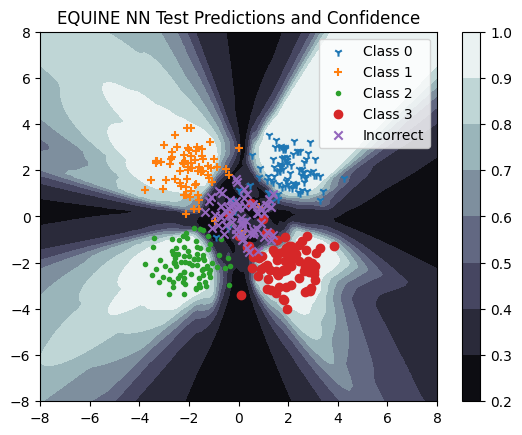

In [10]:
# Using the grid points from before, evaluate EquineGP
res = torch.nn.Softmax(dim=1)(model(test_x)) # Test points
results_grid=torch.nn.Softmax(dim=1)(model(Xs)) # Grid points
y_conf = torch.max(results_grid,1).values.detach()

# Evaluate the results
print_metrics(res, test_y)
display_2d_test_and_confidence(res, test_x, test_y, Xt, Yt, y_conf,
                            "EQUINE NN Test Predictions and Confidence" )


After wrapping with EQUINE, the class confidences are now more reasonably low (25%, a random guess) away from the input training clusters, as well as fairly uniform within the middle, random cluster. This is because `EquineGP` explicitly leverages distances in the embedding space. These distances can also be used to calculate a normalized predictive entropy, which can then be forwarded to the user through the `predict()` method.

### Out of Distribution Indicators
EQUINE introduces the `predict()` method to return predictions with the probability contexts, including
* classes:    the class probabilities
* ood_scores: the out-of-distribution scores

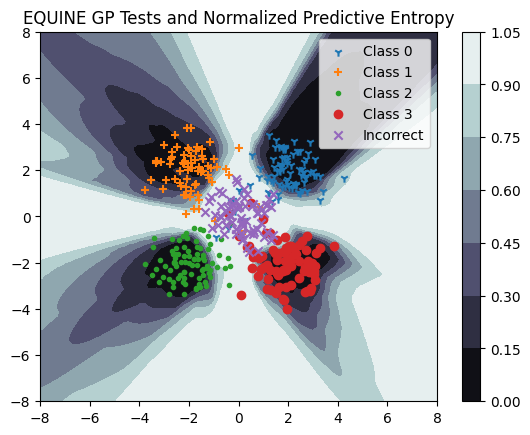

In [11]:
y_ood = (model.predict(Xs).ood_scores).detach()
# Evaluate the results
display_2d_test_and_confidence(res, test_x, test_y, Xt, Yt, y_ood,
                            "EQUINE GP Tests and Normalized Predictive Entropy" )

The OOD scores can then be used as a filter to screen out out-of-distribution predictions, as opposed to simply accepting the outputs and confidence values of the original Neural Network. This shows that, generally, moving away from the training data will lead to higher (close to 1.0) OOD scores.

### Adding an out-of-distribution class
Finally, we illustrate the binary predictive performance on "correct" and "incorrect" predictions that would come from using the OOD scores to screen out predictions on likely OOD data.

In [12]:
# Make a new set of datapoints centered at (6,0)
new_x, _ = make_blobs(n_samples=100, n_features=tensor_dim, 
                        centers=[[6,0]], cluster_std=0.5, shuffle=False,random_state=52)
class4_Xs = torch.FloatTensor(new_x)
class4_Ys = 4*torch.ones(len(new_x),dtype=torch.int)    

# Append to existing test data
ood_test_x= torch.cat((test_x, class4_Xs))
ood_test_y = torch.cat((test_y, class4_Ys))

Neither the vanilla neural network or the EQUINE network knows "out of distribution" cluster, so it's impossible for the networks to correctly predict the new label -- meaning that the cluster appears as a bunch of incorrect predictions to the right of the existing test data.

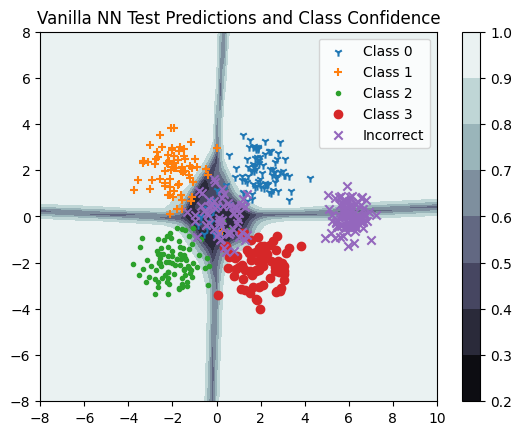

In [13]:
# Compute new results with appended OOD cluster
vanilla_results = torch.nn.Softmax(dim=1)(vanilla_nn(ood_test_x))
vnn_conf_pts = torch.max(vanilla_results,1).values.detach()
vnn_y_classes = torch.argmax(vanilla_results,1)

# Extend the grid to the right a bit to see the new cluster
bbox = 8 
Xt, Yt = torch.meshgrid(torch.linspace(-bbox,bbox+2,steps=100), 
                        torch.linspace(-bbox,bbox,steps=100),
                        indexing='xy')
Xs = torch.cat(tuple(torch.dstack((Xt,Yt))))
vnn_results_grid=torch.nn.Softmax(dim=1)(vanilla_nn(Xs))
vnn_conf = torch.max(vnn_results_grid,1).values.detach()

display_2d_test_and_confidence(vanilla_results, ood_test_x, ood_test_y, Xt, Yt, vnn_conf,
                            "Vanilla NN Test Predictions and Class Confidence")

Finally, we illustrate the binary predictive performance on "correct" and "incorrect" predictions that would come from using the OOD scores to screen out predictions on likely OOD data. To do this, we'll generate a ROC curve using 1-OOD scores (something like an "in-distribution" score) as a confidence threshold for EQUINE, and the maximum probability for the vanilla Neural Network. 

Note that these ROC curves could be made *arbitrarily worse* for the Vanilla Neural Network by adding more OOD test points and/or more OOD data clusters; the point is just to show how EQUINE's `ood_scores` can be used to filter out predictions on OOD data. 

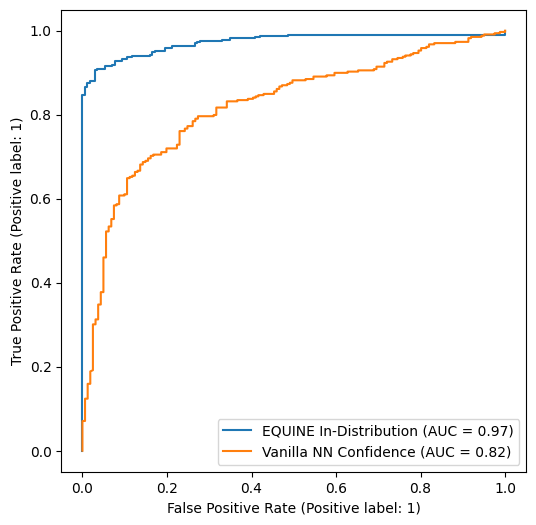

In [14]:
# Let's see how well the confidence does at figuring ou
vnn_correct = (vnn_y_classes == ood_test_y)

# Generate results for the EQUINE protonet
eq_results=model.predict(ood_test_x)
eq_y_classes = torch.argmax(eq_results.classes,1)
eq_correct = (eq_y_classes == ood_test_y)

# Show the performance 
fig, ax = plt.subplots(figsize=(6, 6))
RocCurveDisplay.from_predictions(eq_correct, 1.0-eq_results.ood_scores.detach().numpy(), name="EQUINE In-Distribution", ax=ax)
RocCurveDisplay.from_predictions(vnn_correct, vnn_conf_pts, name="Vanilla NN Confidence", ax=ax)

In [15]:
# save the model
model.save("toy_example_GP.eq")

# save the test set as a TensorDataset that can be uploaded to the webapp for visualization
torch.save(TensorDataset(test_x, test_y), "toy_test_GP_data.pt")